<a href="https://colab.research.google.com/github/WestChaeVI/Segmentation/blob/main/Unet_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image as PILImage
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

Note that we have two folders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` folder image.

# Generators

In [4]:
# Numpy N-dims Array X
# image, image -> 4D tensor --> Train 배치 사이즈 포함
# Image_generator
#  U-Net Input 2*n
def image_generator(files, batch_size = 32, sz = (256, 256)):

  while True: 
    
    # image file 중 32장을 랜덤하게 골라라
    # 32개의 index를 뽑아 줍니다. 
    batch = np.random.choice(files, size = batch_size) # 이미지 파일의 경로들을 배치단위로 뽑아오는 것

    # list for Image, Mask
    batch_x = []
    batch_y = []
    
    # batch -> list
    for f in batch:
        #get the masks. Note that masks are png files 
        # Image -> Random -> Read -> Resize (256, 256)
        # path = 'annotations/trimaps/{}.png'.format(f[:-4])
        mask = PILImage.open(f'annotations/trimaps/{f[:-4]}.png') # 경로를 뽑아왔으니 for문에서 PIL로 open해주는 것임 -> annotation 이미지가 안보이는 건 mask인 라벨 이미지인데 너무 작은 픽셀값이라 까맣게 보이는 것
        mask = np.array(mask.resize(sz)) # 읽은 이미지를 resize해서 np로 읽어 줌
        
        #preprocess the binary mask 
        mask[mask >= 2] = 0           # -> 0 or 1로 마스크를 처리해줌 (1,2,3의 값으로 채워져있는 것 같음 )
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = PILImage.open(f'images/{f}') 
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        # if GRAY (256, 256) --> Length of Tuple ? 2
        # elif Color (256, 256, 3) --> Length of Tuple ? 3
        #  GRAY ? Color

        if len(raw.shape) == 2: # gray 스케일이냐 or color냐? len==2이면, 256 256 흑백 스케일이니까
          raw = np.stack((raw,)*3, axis=-1) # 3장을 쌓아서 3채널을 만들어줌

        else:
          raw = raw[:,:,0:3] # 이건 걍 컬러 이미지

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255. # numpy배열 & to tensor
    batch_y = np.array(batch_y)
    # (32, 256, 256)
    batch_y = np.expand_dims(batch_y,3) # batch_y = np.expand_dims(batch_y,-1) 이렇게 만들어준 것 굳이 끝에 1이라는 차원을 넣어줘야하나봄
    # (32, 256, 256, 1)

    yield (batch_x, batch_y) 
    
    # batch_x: 32, 256, 256, 3
    # batch_y: 32, 256, 256, 1 

In [5]:
batch_size = 32

all_files = os.listdir('images')
# get all files in images folder
# list 
shuffle(all_files) # 셔플

# len(all_files) -> N? 
# 0.95 -> training, 0.05 --> Validation
split = int(0.95 * len(all_files)) # train/test 스플릿

#split into training and testing
train_files = all_files[0:split] # 95프로 train
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [6]:
x, y= next(train_generator)
x,y

(array([[[[0.25882353, 0.25490196, 0.23921569],
          [0.26666667, 0.25882353, 0.25490196],
          [0.27058824, 0.26666667, 0.25882353],
          ...,
          [0.24705882, 0.24705882, 0.23921569],
          [0.24705882, 0.24705882, 0.24313725],
          [0.24705882, 0.23921569, 0.22745098]],
 
         [[0.2627451 , 0.25882353, 0.24705882],
          [0.27058824, 0.26666667, 0.25490196],
          [0.2745098 , 0.26666667, 0.25882353],
          ...,
          [0.24705882, 0.24313725, 0.24313725],
          [0.24705882, 0.24705882, 0.23921569],
          [0.24705882, 0.24705882, 0.23529412]],
 
         [[0.25882353, 0.25882353, 0.25098039],
          [0.26666667, 0.26666667, 0.24705882],
          [0.2745098 , 0.26666667, 0.25882353],
          ...,
          [0.25490196, 0.25882353, 0.24705882],
          [0.25098039, 0.25098039, 0.25098039],
          [0.25490196, 0.24705882, 0.24313725]],
 
         ...,
 
         [[0.88627451, 0.88235294, 0.86666667],
          [0.89411

In [7]:
print (x.shape, y.shape) # Tensorflow는 (B, H, W, C) / Pytorch는 (B, C, H, W)

(32, 256, 256, 3) (32, 256, 256, 1)


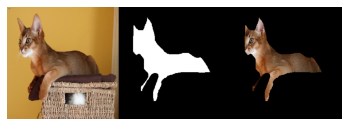

In [8]:
plt.axis('off')
img = x[5]
# (256, 256, 3)
msk = y[5].squeeze()
# (256,256, 1) --> (256, 256)으로 해주는 것이 squeeze
# (256, 256)
msk = np.stack((msk,)*3, axis=-1) # 이미지는 3채널이 있으니 마스크도 3채널을 만들어준 뒤, 아래처럼 분류한 이미지를 만들어준 것 
# Image (256, 256, 3) * Mask (256, 256, 3)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [9]:
# 교집합/합집합 -> 예측, 정답segmentation 영역의 합집합으로 겹치는 픽셀부분을 나눈 것임
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32') # binary로 했기 때문에 0.5 임계값
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou # loss func으로 쓰일 수 있다.

# Model

In [10]:
def conv_block(x, nkernels):
  x = Conv2D(nkernels, (3,3), activation='relu', kernel_initializer ='he_normal', use_bias=False, padding='same') (x) # 
  x = BatchNormalization()(x)

In [11]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  nkernels = 64 # 내맘
  # number of output feature 
  
  #layers = []
  # (32, 256, 256, 3)
  layer11 = Conv2D(nkernels, (3,3), activation='relu', padding='same') (x)
  # layer11 : (32, 256, 256, 64)
  layer12 = Conv2D(nkernels, (3,3), activation='relu', padding='same') (layer11)
  # (32, 256, 256, 64)
  layer13 = MaxPooling2D() (layer12)
  # (32, 128, 128, 64)

  layer21 = Conv2D(nkernels*2, (3,3), activation='relu', padding='same') (layer13)
  # (32, 128, 128, 128) 2배로 개수 늘려 줌
  layer22 = Conv2D(nkernels*2, (3,3), activation='relu', padding='same') (layer21)
  # (32, 128, 128, 128)
  layer23 = MaxPooling2D() (layer22)
  # (32, 64, 64, 128)

  layer31 = Conv2D(nkernels*4, (3,3), activation='relu', padding='same') (layer23)
  # (32, 64, 64, 256) 2배로 개수 늘려 줌
  layer32 = Conv2D(nkernels*4, (3,3), activation='relu', padding='same') (layer31)
  # (32, 64, 64, 256)
  layer33 = MaxPooling2D() (layer32)
  # (32, 32, 32, 256)

  layer41 = Conv2D(nkernels*8, (3,3), activation='relu', padding='same') (layer33)
  # (32, 32, 32, 512)
  layer42 = Conv2D(nkernels*8, (3,3), activation='relu', padding='same') (layer41)
  # (32, 32, 32, 512)
  layer43 = MaxPooling2D() (layer42)
  # (32, 16, 16, 512)

  layer51 = Conv2D(nkernels*16, (3,3), activation='relu', padding='same') (layer43)
  # (32, 16, 16, 1024)

# 여기서부터 반으로 줄이면서 upsampling
  layer52 = Conv2D(nkernels*8, (3,3), activation='relu', padding='same') (layer51)
  # (32, 16, 16, 512)

  layer61 = UpSampling2D()(layer52) # 이거는 nerest neighbor 보간으로 키우기만 함
  # (32, 32, 32, 512)
  layer62 = Concatenate(axis=3)([layer61, layer42]) # 여기서부터 concat이 이루어지는데, 42에서 나온 같은 사이즈의 fm을 concat해줌(skip connection)
  # (32, 32, 32, 1024)
  layer63 = Conv2D(nkernels*8, (3,3), activation='relu', padding='same') (layer62)
  # (32, 32, 32, 512)
  layer64 = Conv2D(nkernels*4, (3,3), activation='relu', padding='same') (layer63)
  # (32, 32, 32, 256)

  layer71 = UpSampling2D()(layer64) 
  # (32, 64, 64, 256)
  layer72 = Concatenate(axis=3)([layer71, layer32])
  # (32, 64, 64, 512)
  layer73 = Conv2D(nkernels*4, (3,3), activation='relu', padding='same') (layer72)
  # (32, 64, 64, 256)
  layer74 = Conv2D(nkernels*2, (3,3), activation='relu', padding='same') (layer73)
  # (32, 64, 64, 128)

  layer81 = UpSampling2D()(layer74)
  # (32, 128, 128, 128)
  layer82 = Concatenate(axis=3)([layer81, layer22])
  # (32, 128, 128, 256)
  layer83 = Conv2D(nkernels*2, (3,3), activation='relu', padding='same') (layer82)
  # (32, 128, 128, 128)
  layer84 = Conv2D(nkernels, (3,3), activation='relu', padding='same') (layer83)
  # (32, 128, 128, 64)

  layer91 = UpSampling2D()(layer84)
  # (32, 256, 256, 64)
  layer92 = Concatenate(axis=3)([layer91, layer12])
  # (32, 256, 256, 128)
  layer93 = Conv2D(nkernels, (3,3), activation='relu', padding='same') (layer92)
  # (32, 256, 256, 64)
  layer94 = Conv2D(nkernels, (3,3), activation='relu', padding='same') (layer93)
  # (32, 256, 256, 64)

  outputs = Conv2D(1, (3,3), activation='sigmoid', padding='same') (layer94)
  # (32, 256, 256, 1)

  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou]) # sigmoid라서 이진 크로스엔트로피 이용
  
  return model

In [13]:
model = unet()

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [15]:
def build_callbacks(): # 한 eopch 이후 부를 함수 지정
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files) # test 파일중 하나 초이스
        raw = PILImage.open(f'images/{path}') # 그 이미지를 부름
        raw = np.array(raw.resize((256, 256)))/255. # 똑같이 정규화
        raw = raw[:,:,0:3] 
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze() # 마스크의 쓸데없는 채널을 스퀴즈로 날려줌
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 # 마스크가 선형이기에 임계값 넣어주기
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

<ipython-input-16-1f8129f74ea5>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs = 30, steps_per_epoch = train_steps, validation_data = test_generator, validation_steps = test_steps, callbacks = build_callbacks(), verbose = 0)


i= 1 loss= 0.5896459221839905 val_loss= 0.5605719685554504 mean_iou= 6.912057870067656e-06 val_mean_iou= 0.0
1/1 [==============================] - 1s 1s/step


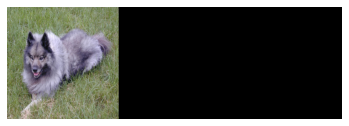

i= 2 loss= 0.5452067255973816 val_loss= 0.538989782333374 mean_iou= 0.0013659492833539844 val_mean_iou= 0.0
1/1 [==============================] - 0s 21ms/step


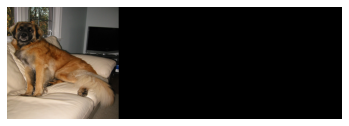

i= 3 loss= 0.5069557428359985 val_loss= 0.46050044894218445 mean_iou= 0.18890845775604248 val_mean_iou= 0.46524283289909363
1/1 [==============================] - 0s 21ms/step


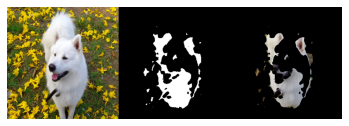

i= 4 loss= 0.4563448429107666 val_loss= 0.4250744879245758 mean_iou= 0.40475645661354065 val_mean_iou= 0.42141658067703247
1/1 [==============================] - 0s 20ms/step


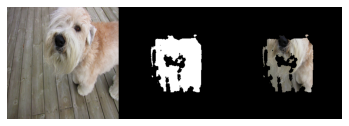

i= 5 loss= 0.4303895831108093 val_loss= 0.4236004948616028 mean_iou= 0.4478413462638855 val_mean_iou= 0.44717785716056824
1/1 [==============================] - 0s 21ms/step


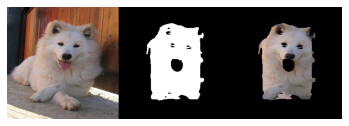

i= 6 loss= 0.4177645742893219 val_loss= 0.3969895541667938 mean_iou= 0.4677972197532654 val_mean_iou= 0.4786350131034851
1/1 [==============================] - 0s 22ms/step


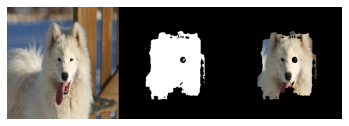

i= 7 loss= 0.41778963804244995 val_loss= 0.3935530483722687 mean_iou= 0.46770039200782776 val_mean_iou= 0.46594923734664917
1/1 [==============================] - 0s 23ms/step


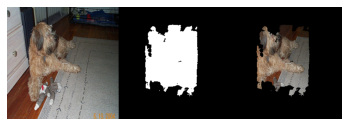

i= 8 loss= 0.4102238416671753 val_loss= 0.3802618086338043 mean_iou= 0.4776105284690857 val_mean_iou= 0.46072280406951904
1/1 [==============================] - 0s 23ms/step


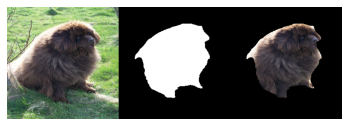

i= 9 loss= 0.40386202931404114 val_loss= 0.40532293915748596 mean_iou= 0.48806285858154297 val_mean_iou= 0.4336291551589966
1/1 [==============================] - 0s 23ms/step


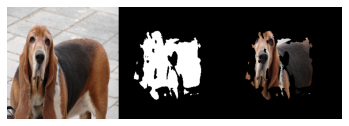

i= 10 loss= 0.39198964834213257 val_loss= 0.3687762916088104 mean_iou= 0.5050387382507324 val_mean_iou= 0.5165972113609314
1/1 [==============================] - 0s 20ms/step


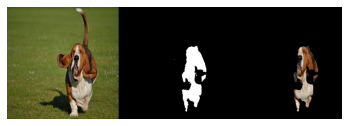

i= 11 loss= 0.374472051858902 val_loss= 0.3310813307762146 mean_iou= 0.5332432985305786 val_mean_iou= 0.625851035118103
1/1 [==============================] - 0s 22ms/step


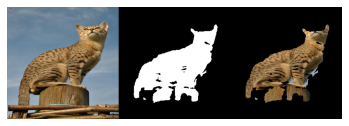

i= 12 loss= 0.35504743456840515 val_loss= 0.29518744349479675 mean_iou= 0.56099933385849 val_mean_iou= 0.6356244683265686
1/1 [==============================] - 0s 22ms/step


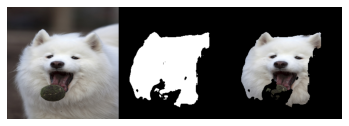

i= 13 loss= 0.3323882520198822 val_loss= 0.2881677448749542 mean_iou= 0.5939820408821106 val_mean_iou= 0.6450163722038269
1/1 [==============================] - 0s 23ms/step


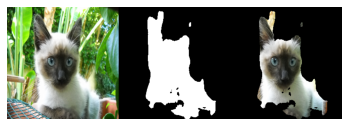

i= 14 loss= 0.3100495934486389 val_loss= 0.2823662757873535 mean_iou= 0.6293999552726746 val_mean_iou= 0.6124929189682007
1/1 [==============================] - 0s 32ms/step


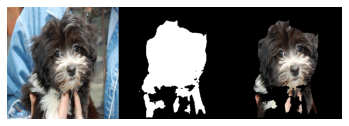

i= 15 loss= 0.28489938378334045 val_loss= 0.2610468566417694 mean_iou= 0.6548988819122314 val_mean_iou= 0.6920799612998962
1/1 [==============================] - 0s 22ms/step


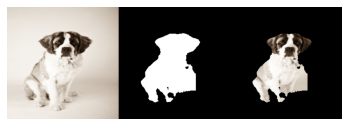

i= 16 loss= 0.2722093164920807 val_loss= 0.2862144708633423 mean_iou= 0.67267906665802 val_mean_iou= 0.6353375315666199
1/1 [==============================] - 0s 21ms/step


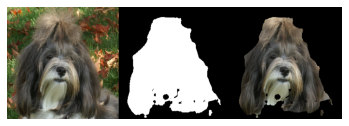

i= 17 loss= 0.25344571471214294 val_loss= 0.29658451676368713 mean_iou= 0.69301837682724 val_mean_iou= 0.6370853781700134
1/1 [==============================] - 0s 20ms/step


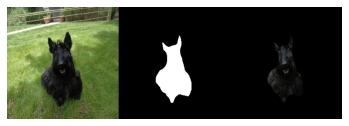

i= 18 loss= 0.24367228150367737 val_loss= 0.2282305657863617 mean_iou= 0.7091947793960571 val_mean_iou= 0.7160499691963196
1/1 [==============================] - 0s 29ms/step


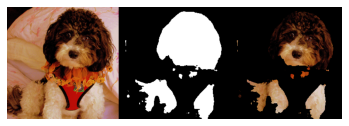

i= 19 loss= 0.2249910831451416 val_loss= 0.34246575832366943 mean_iou= 0.7307767271995544 val_mean_iou= 0.6494836211204529
1/1 [==============================] - 0s 28ms/step


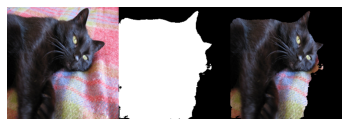

i= 20 loss= 0.21402917802333832 val_loss= 0.2007700353860855 mean_iou= 0.7410393357276917 val_mean_iou= 0.7681049704551697
1/1 [==============================] - 0s 32ms/step


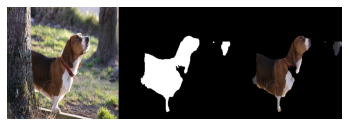

i= 21 loss= 0.2068355530500412 val_loss= 0.17757105827331543 mean_iou= 0.7512101531028748 val_mean_iou= 0.7657325863838196
1/1 [==============================] - 0s 23ms/step


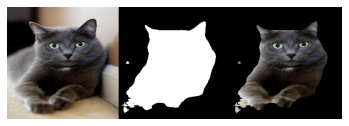

i= 22 loss= 0.19191978871822357 val_loss= 0.1851148009300232 mean_iou= 0.7690694332122803 val_mean_iou= 0.7759113311767578
1/1 [==============================] - 0s 21ms/step


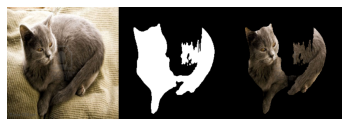

i= 23 loss= 0.18724295496940613 val_loss= 0.21721592545509338 mean_iou= 0.7733590602874756 val_mean_iou= 0.7644389867782593
1/1 [==============================] - 0s 21ms/step


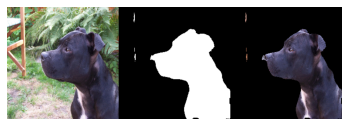

i= 24 loss= 0.18249154090881348 val_loss= 0.2642262279987335 mean_iou= 0.7826398611068726 val_mean_iou= 0.7163590788841248
1/1 [==============================] - 0s 33ms/step


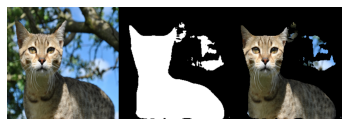

i= 25 loss= 0.17110885679721832 val_loss= 0.20420332252979279 mean_iou= 0.7920448780059814 val_mean_iou= 0.7611057758331299
1/1 [==============================] - 0s 21ms/step


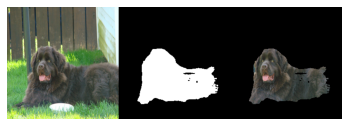

i= 26 loss= 0.16434289515018463 val_loss= 0.17079223692417145 mean_iou= 0.7972531914710999 val_mean_iou= 0.7786067724227905
1/1 [==============================] - 0s 21ms/step


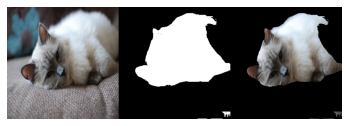

i= 27 loss= 0.15498307347297668 val_loss= 0.1805250495672226 mean_iou= 0.8098858594894409 val_mean_iou= 0.7852236032485962
1/1 [==============================] - 0s 20ms/step


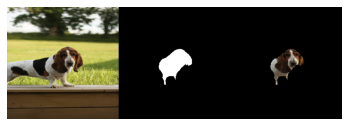

i= 28 loss= 0.15205168724060059 val_loss= 0.1722460240125656 mean_iou= 0.8141805529594421 val_mean_iou= 0.7956905961036682
1/1 [==============================] - 0s 31ms/step


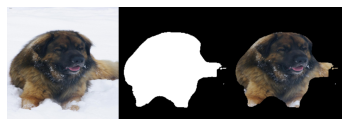

i= 29 loss= 0.14581862092018127 val_loss= 0.16052615642547607 mean_iou= 0.8213618993759155 val_mean_iou= 0.8023900985717773
1/1 [==============================] - 0s 23ms/step


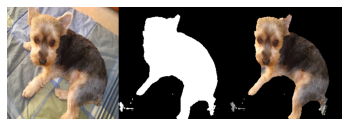

i= 30 loss= 0.1398201435804367 val_loss= 0.2132682353258133 mean_iou= 0.8278528451919556 val_mean_iou= 0.7633227705955505
1/1 [==============================] - 0s 20ms/step


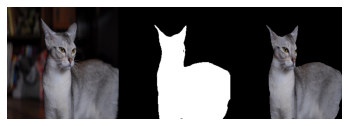

In [16]:
train_steps = len(train_files) //batch_size # iteration
test_steps = len(test_files) //batch_size 

model.fit_generator(train_generator, epochs = 30, steps_per_epoch = train_steps, validation_data = test_generator, validation_steps = test_steps, callbacks = build_callbacks(), verbose = 0)

# Testing

In [17]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2023-02-15 06:37:28--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.33.88.57, 13.33.88.38, 13.33.88.118, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.33.88.57|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.001s  

2023-02-15 06:37:28 (44.5 MB/s) - ‘test.jpg’ saved [63219/63219]



1/1 [==============================] - 0s 35ms/step


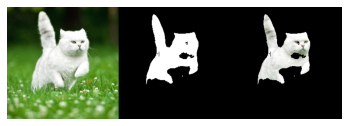

In [19]:
raw = PILImage.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

